In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [80]:
# Python SQL toolkit and Object Relational Mapper
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func, inspect, and_, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new mode
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Precipitation Analysis

In [87]:
# Find the most recent date in the data set.
precipitation_subquery = session.query(func.max(Measurement.date)).scalar_subquery()
session.query(precipitation_subquery).scalar()
#('2017-08-23',)

'2017-08-23'

SELECT measurement.date, measurement.prcp 
FROM measurement 
WHERE measurement.date >= date((SELECT max(measurement.date) AS max_1 
FROM measurement), :date_1) AND measurement.prcp IS NOT NULL


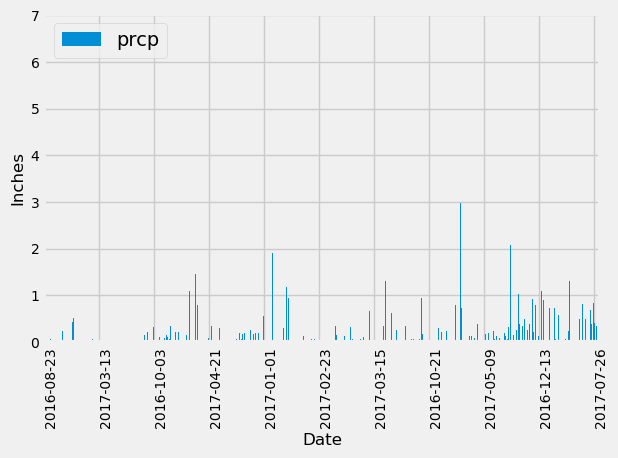

In [98]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the data and precipitation scores
precipitation_query = (
    session.query(
        Measurement.date,
        Measurement.prcp
    )
    .filter(
        and_(
            Measurement.date >= func.date(precipitation_subquery, '-12 months'),
            Measurement.prcp.isnot(None)
        )
    )
).statement

print(precipitation_query)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = inspector.get_columns('measurement')
precipitation_df = pd.read_sql(precipitation_query, engine, columns=column_names)

# Sort the dataframe by date
precipitations_df = precipitation_df.sort_values(by=['date'])
precipitation_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(kind="bar", x="date", y="prcp")

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))
plt.xticks(ha='left', fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Inches", fontsize=12)
plt.tight_layout()
plt.show()

In [96]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [70]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(func.distinct(Measurement.station))).scalar_subquery()
session.query(station_count).scalar()

9

In [83]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(Measurement.station, 
              func.count(Measurement.station).label('station_count')
              ).group_by(Measurement.station).order_by(desc('station_count')).all()



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [86]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs).label('min_temp'), 
              func.max(Measurement.tobs).label('max_temp'),
              func.avg(Measurement.tobs).label('avg_temp')
              ).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [99]:
# Close Session
session.close()